Where the yuppies at? Measuring gentrification using chain stores.

In [1]:
from yelp.client import Client
from yelp.oauth1_authenticator import Oauth1Authenticator
from yelp.errors import BusinessUnavailable
import os
import json
import pandas as pd
import folium
import geojson
import random
import requests
import numpy as np
from geopy.distance import vincenty

In [2]:
%ls "../auth"

 Volume in drive C is SSD_80GB
 Volume Serial Number is 9279-00B2

 Directory of C:\Users\Alex\Desktop\nyc-gentrification\auth

01/14/2017  03:37 PM    <DIR>          .
01/14/2017  03:37 PM    <DIR>          ..
01/14/2017  03:37 PM               207 yelp.json
               1 File(s)            207 bytes
               2 Dir(s)   2,089,754,624 bytes free


In [3]:
# This code originally from https://github.com/ResidentMario/chain-incidence/blob/master/chain-incidence.ipynb

def import_credentials(filename='../auth/yelp.json'):
    """
    Finds the credentials file describing the token that's needed to access Yelp services.

    :param filename -- The filename at which Yelp service credentials are stored. Defaults to
    `yelp_credentials.json`.
    """
    try:
        with open(filename) as f:
            return json.load(f)
    except IOError as e:
        raise e('This API requires Yelp credentials to work. Did you forget to define them?')

def fetch_businesses(name, area='New York', manual_override=0):
    area = area.lower().replace(' ', '-')
    name = name.lower().replace(' ', '-')
    """
    Fetches all yelp.obj.business_response.BusinessResponse objects for incidences of the given chain in Manhattan.
    Constructs Yelp business ids for incidences of the chain in the area, then queries Yelp to check if they
    exist.
    IDs are constructed name-location-number, so we just have to check numbers in ascending order until it breaks.
    e.g. http://www.yelp.com/biz/gregorys-coffee-new-york-18 is good.
         http://www.yelp.com/biz/gregorys-coffee-new-york-200 is not.
    Then we do reverse GIS searches using the business ID through the Yelp API and extract coordinates from the results.
    Some technical notes:
    1.  The first incidence of any store in the area is reported without any numeral.
        e.g. "dunkin-donuts-new-york", not "dunkin-donuts-new-york-1".
        Numbers pick up from there: the next shitty hole in the wall will be "dunkin-donuts-new-york-2".
    2.  Yelp IDs are unique and are not reassigned when a location is closed.
        Thus we need to check for and exclude closed locations when munging the data.
    3.  Places with a single instance in Manhattan sometimes have a "name-place-2" that redirects to their only location.
        At least this seems to be the case with Bibble & Sip...
        This is checked and corrected for further down the line, by the fetch_businesses() method.
    4.  Sometimes IDs are given to locations that don't actually really exist.
        e.g. the best-buy-3 id points to a non-existant storefront.
        But best-buy-4, best-buy-5, and so on actually exist!
        Yelp acknowledges this fact, but still returns a BusinessUnavaialable error when queries.
        This method sends a web request and checks the response and terminates on a 404, which has proven to be a reliable
        way of circumnavigating this issue.
    5.  In case the above doesn't work...
        The manual_override parameter forces the fetcher to keep moving past this error.
        For debugging purposes, this method prints a URL for the purposes of manually checking breakpoints.
        That way you can incrementally run fetch() and then comb over trouble spots you find by moving up manual_override.
        If you hit that URL and you get either a valid ID or an invalid but existing ID, you need to bump up manual_override
        to correct it and rerun the fetch.
        If you hit that URL and you get a 404 page then you're done!
        e.x. In the Best Buy case both best-buy-3 and best-buy-10 are phantoms.
        But once we set manual_override=10 we're good, and get all of the actual storefronts.
    """
    i = 2
    # Run the first one through by hand.
    try:
        responses = [client.get_business("{0}-{1}".format(name, area))]
    # This can happen, and did, in the Dunkin' Donuts case.
    except BusinessUnavailable:
        responses = []
        pass
    # The rest are handled by a loop.
    while True:
        bus_id = "{0}-{1}-{2}".format(name, area, i)
        try:
            response = client.get_business(bus_id)
        except BusinessUnavailable:
            # We manually check trouble spots.
            # But see the TODO.
            if requests.get('http://www.yelp.com/biz/' + bus_id).status_code != requests.codes.ok:
                break
            else:
                # Increment the counter but don't include the troubled ID.
                i += 1
                continue
        responses += [response]
        i += 1
    print("Ended `fetch_businesses()` on:", "http://www.yelp.com/biz/" + bus_id)
    return responses        


def frame(responses):
    """
    Given a list of yelp.obj.business_response.BusinessResponse objects like the one returns by fetch_businesses(),
    builds a coordinate-logging DataFrame out of them.
    """
    latitudes = [response.business.location.coordinate.latitude for response in responses]
    longitudes = [response.business.location.coordinate.longitude for response in responses]
    df = pd.DataFrame({'latitude': latitudes, 'longitude': longitudes})
    df.index.name=responses[0].business.name
    return df


def map_coordinates(df):
    """
    Returns a folium map of all of the coordinates stored in a coordinate DataFrame, like the one returned by frame().
    """
    ret = folium.Map(location=[40.753889, -73.983611], zoom_start=11)
    for row in df.iterrows():
        ret.simple_marker([row[1]['latitude'], row[1]['longitude']])
    return ret


def load_geojson(filename="manhattan.geojson"):
    """
    Returns a geojson object for the given file.
    
    TODO: Add typing logic to distinguish between "Feature" and "FeatureCollection" objects.
    Parsing these is not exactly equivalent. The latter consists of a list of features.
    """
    with open(filename) as f:
        dat = f.read()
        obj = geojson.loads(dat)
    return obj


def load_coordinates(name):
    """
    Loads Manhattan.
    What else?
    Are you surprised?
    """
    # Encode according to our storage scheme.
    filename = name.lower().replace(' ', '_') + '.geojson'
    obj = load_geojson(filename)
    if obj['type'] == 'FeatureCollection':
        ret = []
        for feature in obj['features']:
            ret += list(geojson.utils.coords(feature))
        # return ret
    elif obj['type'] == 'Feature':
        ret = list(geojson.utils.coords(obj))
    # GeoJSON stores coordinates [Longitude, Latitude] -- the "modern" format.
    # For historical reasons, coordinates are usually represented in the format [Latitude, Longitude].
    # And this is indeed the format that the rest of the libraries used for this project expect.
    # So we need to swap the two: [Longitude, Latitude] -> [Latitude, Longitude]
    ret = [(coord[1], coord[0]) for coord in ret]
    return ret


# Borrowed from: http://www.ariel.com.au/a/python-point-int-poly.html
def point_inside_polygon(x, y, poly):
    """
    Checks if a point is inside a polygon.
    Used to validate points as being inside of Manahttan.
    Borrowed from: http://www.ariel.com.au/a/python-point-int-poly.html
    
    The shapely library provides features for this and other things besides, but is too much to deal with at the moment.
    """

    n = len(poly)
    inside = False

    p1x,p1y = poly[0]
    for i in range(n+1):
        p2x,p2y = poly[i % n]
        if y > min(p1y,p2y):
            if y <= max(p1y,p2y):
                if x <= max(p1x,p2x):
                    if p1y != p2y:
                        xints = (y-p1y)*(p2x-p1x)/(p2y-p1y)+p1x
                    if p1x == p2x or x <= xints:
                        inside = not inside
        p1x,p1y = p2x,p2y

    return inside


def generate_sample_points(coordinate_list, n=1000):
    """
    Generates n uniformly distributed sample points within the given coordinate list.
    
    When the geometry is sufficiently complex and the list of points large this query can take a while to process.
    """
    lats, longs = list(map(lambda coords: coords[0], coordinate_list)), list(map(lambda coords: coords[1], coordinate_list))
    max_lat = max(lats)
    min_lat = min(lats)
    max_long = max(longs)
    min_long = min(longs)
    ret = []
    while True:
        p_lat = random.uniform(min_lat, max_lat)
        p_long = random.uniform(min_long, max_long)
        if point_inside_polygon(p_lat, p_long, coordinate_list):
            ret.append((p_lat, p_long))
            if len(ret) > n:
                break
        else:
            continue
    return ret


def sample_points(search_location, n=10000):
    """
    Given the name of the location being search, returns n uniformally distributed points within that location.
    
    Wraps the above.
    """
    return generate_sample_points(load_coordinates(search_location), n)


def get_minimum_distance(coordinate, coordinate_list):
    """
    Naively calculates the minimum distance in the point cloud.
    """
    best_coord = (0, 0)
    best_distance = 1000
    for candidate_coord in coordinate_list:
        dist = vincenty(coordinate, candidate_coord).miles
        if dist < best_distance:
            best_coord = candidate_coord
            best_distance = dist
    return best_distance


def average_distance(chain_name, search_location, point_cloud):
    """
    This is the main function of this notebook!
    Takes the name of the chain in question and the point cloud associated with the location
    for which we are computing average distance.
    Returns the average distance to that chain within that location.
    We ask for a point cloud and not the name of the location because it's more efficient to precompute an extremely large,
    essentially totally random point cloud, and then check against that, instead of recomputing it every round.
    Output is in feet!
    """
    # First load the coordinates corresponding to the search location..
    location_coords = load_coordinates(search_location)
    # Now generate a list of the chains' locations.
    chain_df = frame(fetch_businesses(chain_name))
    chain_coords = list(zip(chain_df['latitude'], chain_df['longitude']))
    # Finally, get and average the minimum distances between the points in the point cloud and the chain locations.
    distances = [get_minimum_distance(point, chain_coords) for point in point_cloud]
    avg = sum(distances)/len(distances)
    avg_in_feet = int(5280*avg)
    return avg_in_feet

In [4]:
credentials = import_credentials()

auth = Oauth1Authenticator(
    consumer_key=credentials['consumer_key'],
    consumer_secret=credentials['consumer_secret'],
    token=credentials['token'],
    token_secret=credentials['token_secret']
)

client = Client(auth)

In [5]:
gregorys = fetch_businesses('Gregorys Coffee')

Ended `fetch_businesses()` on: http://www.yelp.com/biz/gregorys-coffee-new-york-24


In [6]:
map_coordinates(frame(gregorys))

C:\Users\Alex\Anaconda3\envs\nyc-gentrification\lib\site-packages\ipykernel\__main__.py:98: FutureWarning: simple_marker is deprecated. Use add_children(Marker) instead


In [7]:
# redmango = fetch_businesses('Red Mango')

In [8]:
# map_coordinates(frame(redmango))

In [9]:
# ihop = fetch_businesses('IHOP')

In [10]:
# map_coordinates(frame(ihop))

In [11]:
high_variance_gentrifying_chains = [
    ('Chipotle', 67, 51),
    ('Petland Discounts', 63, 11),
    ('New York Sports Clubs', 51, 35),
    ('Pret A Manger', 42, 42),
    ('Le Pain Quotidien', 39, 37),
    ('The Vitamin Shoppe', 38, 20),  # Check the name
    ('Au Bon Pain', 33, 19),
    ('Hale And Hearty', 31, 29),
    ('Red Mango', 29, 16),
    ('Equinox', 26, 25),
    ('Sephora', 24, 16),
    ('Crunch', 23, 14),
    ('Papyrus', 22, 22),
    ('Lids', 20, 13),
    ('Sunglass Hut', 19, 16),
    ('LensCrafters', 19, 16),
    ('Just Salad', 19, 18),
    ('Panera Bread', 18, 7),
    ('Potbelly Sandwich Shop', 17, 16),
    ('Soul Cycle', 17, 15),
    ('H and M', 16, 12),
    ('American Apparel', 16, 12),
    ('J Crew', 15, 14),
    ('Banana Republic', 15, 10),
    ('American Eagle Outfitters', 13, 5),
    ('16 Handles', 13, 8),
    ('Ralph Lauren', 11, 10),
    ('Pinkberry', 11, 10),
    ('Lululemon Athletica', 11, 10),
    ('Tasti D-Lite', 10, 9),
    ('Crumbs Bake Shop', 10, 10),
    ('Barnes And Noble', 9, 5),
    ('Forever 21', 9, 4),
    ('Whole Foods', 9, 8),
    ('Apple Store', 8, 6),
    ('Brooks Brothers', 8, 7)
]
# high_variance_non_gentrifying_chains = [
#     ('Family Dollar', 79, 1), 
#     ('Dollar Tree', 73, 6),
# ]

In [12]:
df_chains = pd.DataFrame(high_variance_gentrifying_chains, columns=['Chain Name', 'Locations', 'Locations in Manhattan'])

In [13]:
df_chains.sum()

Chain Name                ChipotlePetland DiscountsNew York Sports Clubs...
Locations                                                               801
Locations in Manhattan                                                  578
dtype: object

In [14]:
i = 0
locations = []

In [15]:
while i < len(df_chains):
    chain_name = df_chains.iloc[i]['Chain Name']
    locations.append(fetch_businesses(chain_name))
    print(i)
    i += 1

Ended `fetch_businesses()` on: http://www.yelp.com/biz/chipotle-new-york-57
0
Ended `fetch_businesses()` on: http://www.yelp.com/biz/petland-discounts-new-york-21
1
Ended `fetch_businesses()` on: http://www.yelp.com/biz/new-york-sports-clubs-new-york-87
2
Ended `fetch_businesses()` on: http://www.yelp.com/biz/pret-a-manger-new-york-77
3
Ended `fetch_businesses()` on: http://www.yelp.com/biz/le-pain-quotidien-new-york-149
4
Ended `fetch_businesses()` on: http://www.yelp.com/biz/the-vitamin-shoppe-new-york-32
5
Ended `fetch_businesses()` on: http://www.yelp.com/biz/au-bon-pain-new-york-51
6
Ended `fetch_businesses()` on: http://www.yelp.com/biz/hale-and-hearty-new-york-22
7
Ended `fetch_businesses()` on: http://www.yelp.com/biz/red-mango-new-york-34
8
Ended `fetch_businesses()` on: http://www.yelp.com/biz/equinox-new-york-50
9
Ended `fetch_businesses()` on: http://www.yelp.com/biz/sephora-new-york-31
10
Ended `fetch_businesses()` on: http://www.yelp.com/biz/crunch-new-york-55
11
Ended `f

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
chain_names = df_chains['Chain Name'].values

In [18]:
df_locations = pd.concat([frame(location_set).assign(chain=name) for location_set, name in zip(locations, chain_names)])

In [19]:
df_locations.sample(5)

,latitude,longitude,chain
4,40.749523,-73.988144,Lids
34,40.787973,-73.953397,Le Pain Quotidien
24,40.790828,-73.974209,LensCrafters
79,40.765318,-73.957394,Le Pain Quotidien
14,40.743776,-74.006829,Equinox


In [20]:
import shapely

(40.6829, 40.882)

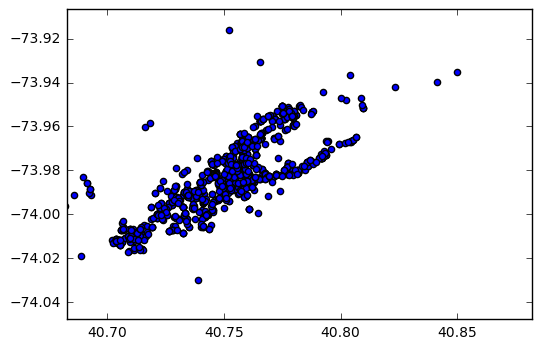

In [21]:
plt.scatter(df_locations['latitude'], df_locations['longitude'])
ax = plt.gca()
ax.set_ylim([-74.0479, -73.9067])
ax.set_xlim([40.6829, 40.8820])

In [22]:
import geopandas as gpd
import requests
import geojson                

In [23]:
with open("../data/boroughs.geojson", "w") as f:
    f.write(requests.get("https://raw.githubusercontent.com/dwillis/nyc-maps/master/boroughs.geojson").text)

In [24]:
boroughs = gpd.read_file("../data/boroughs.geojson")

In [25]:
manhattan_geom = boroughs.query('BoroName == "Manhattan"').geometry.iloc[0]

In [26]:
df_locations_filtered = df_locations[
    df_locations.apply(
        lambda loc: manhattan_geom.contains(shapely.geometry.Point(loc['longitude'], loc['latitude'])), axis=1
    )
]

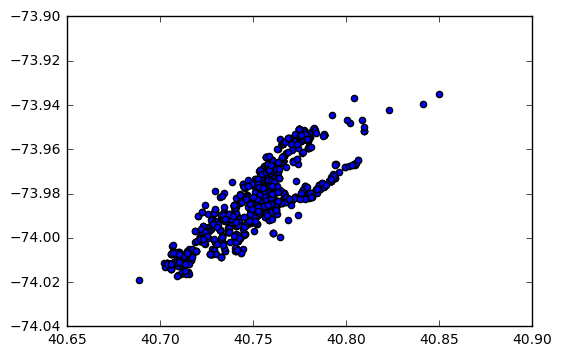

In [27]:
plt.scatter(df_locations_filtered['latitude'], df_locations_filtered['longitude'])

In [28]:
with open("../data/ntas.geojson", "w") as f:
    f.write(requests.get("http://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/nynta/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=geojson").text)

In [29]:
ntas = gpd.read_file("../data/ntas.geojson")

In [30]:
ntas.query('BoroName == "Manhattan"')

,BoroCode,BoroName,CountyFIPS,NTACode,NTAName,OBJECTID,geometry
8,1,Manhattan,061,MN06,Manhattanville,9,"POLYGON ((-73.94607972264011 40.8212714957943,..."
13,1,Manhattan,061,MN15,Clinton,14,"POLYGON ((-73.99383252963101 40.7729400564539,..."
17,1,Manhattan,061,MN11,Central Harlem South,18,"POLYGON ((-73.9417728346951 40.807097276959, -..."
20,1,Manhattan,061,MN17,Midtown-Midtown South,21,"POLYGON ((-73.9730163134895 40.7642871470859, ..."
21,1,Manhattan,061,MN19,Turtle Bay-East Midtown,22,"(POLYGON ((-73.9616307122155 40.7551606505124,..."
40,1,Manhattan,061,MN25,Battery Park City-Lower Manhattan,41,"(POLYGON ((-74.0007843991348 40.69429476862, -..."
48,1,Manhattan,061,MN01,Marble Hill-Inwood,49,(POLYGON ((-73.92152037076541 40.8566094581227...
72,1,Manhattan,061,MN32,Yorkville,73,"(POLYGON ((-73.9380478369022 40.7808378163815,..."
76,1,Manhattan,061,MN40,Upper East Side-Carnegie Hill,77,"POLYGON ((-73.9493331403588 40.7852013986192, ..."
77,1,Manhattan,061,MN33,East Harlem South,78,"POLYGON ((-73.9350544306231 40.7916954772443, ..."


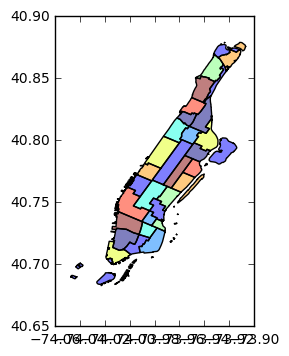

In [31]:
ntas.query('BoroName == "Manhattan"').plot()

In [32]:
with open("../data/tracts.geojson", "w") as f:
    f.write(requests.get("http://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/nyct2010/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=geojson").text)

In [33]:
tracts = gpd.read_file("../data/tracts.geojson")

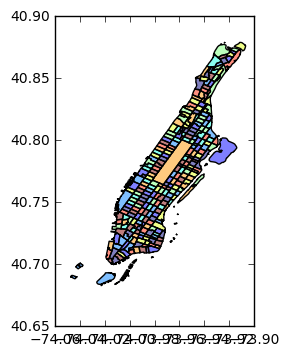

In [34]:
tracts.query('BoroName == "Manhattan"').plot()

In [35]:
len(df_locations_filtered)

1020

In [36]:
from tqdm import tqdm

In [37]:
tract_nums = []
for _, location in tqdm(df_locations_filtered.iterrows()):
    for n, tract in tracts.iterrows():
        if tract.geometry.contains(shapely.geometry.Point(location['longitude'], location['latitude'])):
            tract_nums.append(n)
            break

1020it [02:23,  8.14it/s]


In [38]:
df_locations_filtered = df_locations_filtered.assign(tractnum=tract_nums)

In [39]:
df_locations_filtered.tractnum.isnull().any()

False

In [40]:
df_locations_filtered.tractnum.value_counts().describe()

count    145.000000
mean       7.034483
std        5.925948
min        1.000000
25%        2.000000
50%        5.000000
75%       10.000000
max       28.000000
Name: tractnum, dtype: float64

In [42]:
tractnum_counts = df_locations_filtered.tractnum.value_counts()
tracts['n'] = tractnum_counts

In [107]:
import mplleaflet

In [109]:
tracts.query('BoroName == "Manhattan"').plot(column='n', cmap='Greens', scheme='equal_interval', linewidth=0.5, figsize=(24, 12))
plt.gca().axis('off')
mplleaflet.show()

C:\Users\Alex\Anaconda3\envs\nyc-gentrification\lib\site-packages\pysal\esda\mapclassify.py:259: RuntimeWarning: invalid value encountered in greater
  binIds += (x > l) * (x <= r) * k
C:\Users\Alex\Anaconda3\envs\nyc-gentrification\lib\site-packages\pysal\esda\mapclassify.py:259: RuntimeWarning: invalid value encountered in less_equal
  binIds += (x > l) * (x <= r) * k
C:\Users\Alex\Anaconda3\envs\nyc-gentrification\lib\site-packages\numpy\lib\function_base.py:3569: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


In [ ]:
mplleaflet.show()

In [108]:
mplleaflet.show()

<module 'mplleaflet' from 'C:\\Users\\Alex\\Anaconda3\\envs\\nyc-gentrification\\lib\\site-packages\\mplleaflet\\__init__.py'>

In [59]:
nta_nums = []
for _, location in tqdm(df_locations_filtered.iterrows()):
    for n, nta in ntas.iterrows():
        if nta.geometry.contains(shapely.geometry.Point(location['longitude'], location['latitude'])):
            nta_nums.append(n)
            break

1020it [00:09, 105.53it/s]


In [65]:
df_locations_filtered = df_locations_filtered.assign(ntanum=nta_nums)
ntanum_counts = df_locations_filtered.ntanum.value_counts()
ntas['n'] = ntanum_counts

In [75]:
len(ntas.query('BoroName == "Manhattan"'))

29

In [74]:
len(ntanum_counts)

25

In [66]:
ntas.query('BoroName == "Manhattan"')['n']

8        NaN
13      25.0
17       7.0
20     237.0
21      78.0
40      67.0
48       NaN
72      26.0
76      62.0
77      11.0
82      39.0
86      22.0
94      10.0
95       1.0
99      59.0
100     50.0
104     89.0
105     89.0
121     84.0
122      4.0
123      NaN
124     17.0
125      3.0
147      1.0
148     34.0
183      NaN
184      1.0
193      1.0
194      3.0
Name: n, dtype: float64

In [70]:
ntas.n.value_counts().describe()

count    20.00000
mean      1.25000
std       0.71635
min       1.00000
25%       1.00000
50%       1.00000
75%       1.00000
max       4.00000
Name: n, dtype: float64

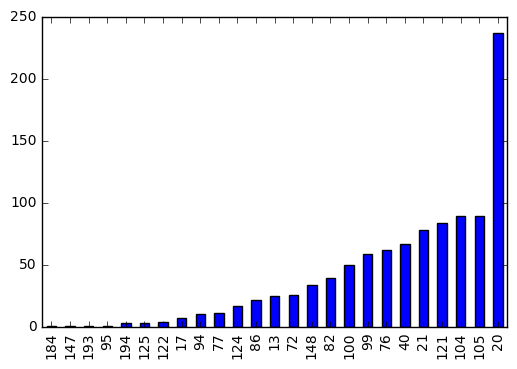

In [84]:
ntas.query('BoroName == "Manhattan"').dropna().n.sort_values().plot(kind='bar')

(-74.060000000000002,
 -73.900000000000006,
 40.650000000000006,
 40.900000000000006)

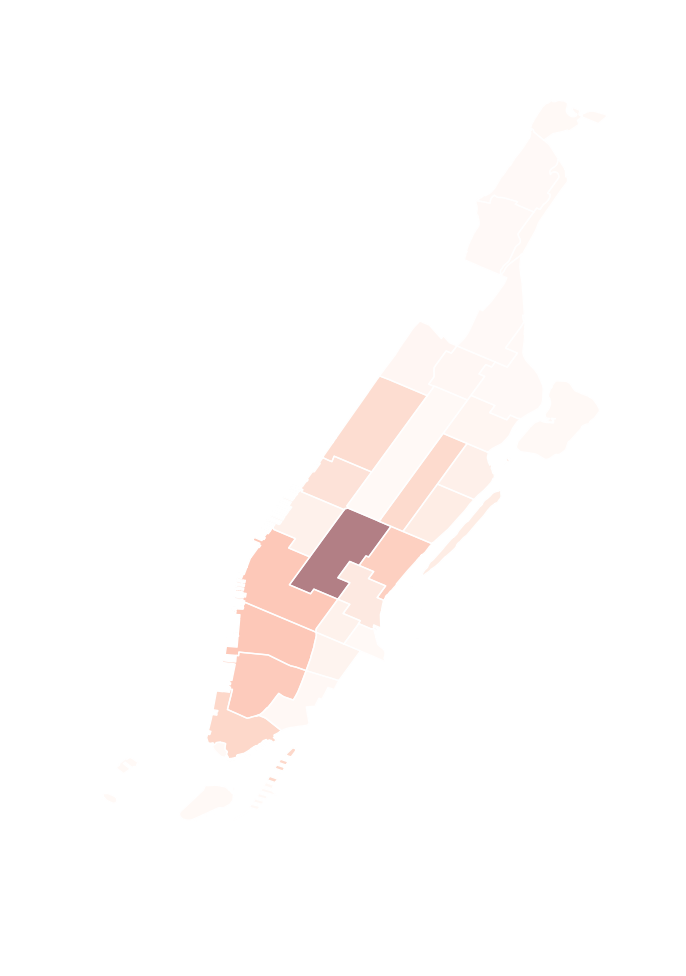

In [100]:
ntas.query('BoroName == "Manhattan"').dropna().plot(column='n', linewidth=1, edgecolor='white', figsize=(24, 12), cmap='Reds')
plt.gca().axis('off')

In [110]:
ntas.query('BoroName == "Manhattan"').dropna().plot(column='n', linewidth=1, edgecolor='white', figsize=(24, 12), cmap='Reds')
plt.gca().axis('off')
mplleaflet.show()

In [111]:
df_locations_filtered.to_csv("../data/locations.csv", index=False)

In [41]:
# multipoints = []
# for tractnum in tqdm(tracts.index):
#     locs_in_tract = df_locations_filtered[df_locations_filtered.tractnum == tractnum]
#     if len(locs_in_tract) > 0:
#         multipoints.append(shapely.geometry.MultiPoint(locs_in_tract.apply(lambda d: shapely.geometry.Point(d['longitude'], d['latitude']), axis=1).values))
#     elif len(locs_in_tract) == 1:
#         multipoints.append(shapely.geometry.Point(locs_in_tract.apply(lambda d: [d['longitude'], d['latitude']], axis=1).iloc[0]))        
#     else:
#         multipoints.append(shapely.geometry.Point(0, 0))